In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ImageFit.py



%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sini = 0.5
g1 = 0.0
g2 = 0.0

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=g2)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)


eobs_thy: 0.13636363636363635
slitAng_major_p: 0.0
slitAng_minor_p: 90.0


In [3]:
update_TF, _ = get_TFcube_pars()

update_TF['slitAngles'] = np.array([0.])

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185# 0.1185  # 0.032 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128

In [4]:
def cal_e_obs_bias_err(update_TF):
    
    TF_pars, meta_parameters = get_TFcube_pars(update_TF)

    data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)

    # make data_info from Prangal's data output
    data_info = {}
    data_info['ModelCube'] = None
    data_info['ObsCube'] = None
    data_info['image'] = data['image']
    data_info['image_variance'] = noise['image']

    if len(TF_pars['slitAngles']) == 1:
        data_info['data'] = data['spectra'][0]
    else:
        #data_info['data'] = data['spectra'][0] # this line is to make it compatible with older branches... 
        data_info['data_major'] = data['spectra'][0]
        data_info['data_minor'] = data['spectra'][1]
    
    data_info['grid_lambda'] = obslambda

    extent =  TF_pars['image_size'] * TF_pars['pixScale']
    subGridPixScale = extent*1./TF_pars['ngrid']

    data_info['grid_pos']    = np.arange(-extent/2., extent/2., subGridPixScale)
    data_info['grid_Image']  = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
    data_info['par_fid']     = TF_pars
    data_info['lambda_emit'] = 656.461 # Halpha [nm]
    
    # Fitting procress
    
    ImFit = ImageFit(data_info=data_info)
    
    
    chainImage_info = ImFit.run_MCMC(Nwalker=50, Nsteps=1000)

    Chain_Image = ChainTool(chainImage_info, Nburn=30000, Nend=50000)
    
    e_obs_bestfit, e_obs_err = Chain_Image.par_bestfit(select_par_key=['e_obs'], statistics='max', mode=1)
    e_obs_bias = e_obs_bestfit[0] - eobs_thy
    e_obs_err = e_obs_err[0]
    
    return e_obs_bias, e_obs_err

In [19]:
list_e_obs_bias = []
list_e_obs_err = []

for j in range(50):
    print(f"run:{j}")

    e_obs_bias, e_obs_err = cal_e_obs_bias_err(update_TF)
    
    list_e_obs_bias.append(e_obs_bias)
    list_e_obs_err.append(e_obs_err)

run:0
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:00<00:00, 16.45it/s]


Total MCMC time (mins): 1.013922667503357
run:1
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.04it/s]


Total MCMC time (mins): 0.9791305621465047
run:2
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]


Total MCMC time (mins): 0.9959083159764608
run:3
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


Total MCMC time (mins): 0.9433868130048116
run:4
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


Total MCMC time (mins): 0.9073604663213094
run:5
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:54<00:00, 18.37it/s]


Total MCMC time (mins): 0.9083433826764424
run:6
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:53<00:00, 18.53it/s]


Total MCMC time (mins): 0.9001226226488749
run:7
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:55<00:00, 18.09it/s]


Total MCMC time (mins): 0.9222674528757732
run:8
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:59<00:00, 16.79it/s]


Total MCMC time (mins): 0.9938862800598145
run:9
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:59<00:00, 16.80it/s]


Total MCMC time (mins): 0.9928473989168803
run:10
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:00<00:00, 16.52it/s]


Total MCMC time (mins): 1.0095188697179158
run:11
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:56<00:00, 17.69it/s]


Total MCMC time (mins): 0.9428348342577616
run:12
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s]


Total MCMC time (mins): 0.9415927529335022
run:13
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:54<00:00, 18.45it/s]


Total MCMC time (mins): 0.9043601155281067
run:14
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]


Total MCMC time (mins): 0.9400547663370769
run:15
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s]


Total MCMC time (mins): 1.0203861474990845
run:16
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:03<00:00, 15.71it/s]


Total MCMC time (mins): 1.0622266292572022
run:17
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:59<00:00, 16.79it/s]


Total MCMC time (mins): 0.9934990286827088
run:18
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:54<00:00, 18.45it/s]


Total MCMC time (mins): 0.904294216632843
run:19
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


Total MCMC time (mins): 0.9071556647618612
run:20
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:03<00:00, 15.70it/s]


Total MCMC time (mins): 1.0627344806989034
run:21
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s]


Total MCMC time (mins): 0.9341280500094096
run:22
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:57<00:00, 17.34it/s]


Total MCMC time (mins): 0.9621190468470255
run:23
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


Total MCMC time (mins): 0.955327566464742
run:24
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.23it/s]


Total MCMC time (mins): 0.9684495488802592
run:25
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]


Total MCMC time (mins): 0.9663222153981527
run:26
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


Total MCMC time (mins): 0.9696183681488038
run:27
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.24it/s]


Total MCMC time (mins): 0.967927881081899
run:28
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:57<00:00, 17.44it/s]


Total MCMC time (mins): 0.9566446185112
run:29
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:59<00:00, 16.68it/s]


Total MCMC time (mins): 1.000129552682241
run:30
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:05<00:00, 15.22it/s]


Total MCMC time (mins): 1.0958434700965882
run:31
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:02<00:00, 16.10it/s]


Total MCMC time (mins): 1.0359191338221232
run:32
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:57<00:00, 17.27it/s]


Total MCMC time (mins): 0.9663399974505107
run:33
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


Total MCMC time (mins): 1.048367965221405
run:34
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


Total MCMC time (mins): 0.9525349338849386
run:35
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:57<00:00, 17.46it/s]


Total MCMC time (mins): 0.9554089506467184
run:36
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.23it/s]


Total MCMC time (mins): 0.967987600962321
run:37
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:59<00:00, 16.80it/s]


Total MCMC time (mins): 0.9930305202802022
run:38
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.11it/s]


Total MCMC time (mins): 0.9753568013509114
run:39
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.02it/s]


Total MCMC time (mins): 0.980179230372111
run:40
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.06it/s]


Total MCMC time (mins): 0.9782104810078939
run:41
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.14it/s]


Total MCMC time (mins): 0.9731765309969584
run:42
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s]


Total MCMC time (mins): 1.0399240533510843
run:43
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.23it/s]


Total MCMC time (mins): 0.9683681289354961
run:44
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:58<00:00, 17.19it/s]


Total MCMC time (mins): 0.9702274163564046
run:45
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


Total MCMC time (mins): 0.9092643857002258
run:46
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]


Total MCMC time (mins): 0.9381372173627217
run:47
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:57<00:00, 17.44it/s]


Total MCMC time (mins): 0.9567606210708618
run:48
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


Total MCMC time (mins): 0.9208352963129679
run:49
returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


100%|██████████| 1000/1000 [01:00<00:00, 16.43it/s]

Total MCMC time (mins): 1.0156642516454062


In [20]:
e_obs_bias_sigma = list(np.array(list_e_obs_bias)/np.array(list_e_obs_err))

In [21]:
filename_pkl = "e_obs_g1_0.00_g2_0.00.pkl"
stat_info=load_pickle(filename_pkl)

In [22]:
len(stat_info['e_obs_bias_sigma'])

300

In [23]:
stat_info['e_obs_bias_sigma'] = stat_info['e_obs_bias_sigma'] + e_obs_bias_sigma
stat_info['e_obs_err'] = stat_info['e_obs_err'] + list_e_obs_err
save_pickle(filename_pkl, stat_info)

In [24]:
len(stat_info['e_obs_bias_sigma'])

350

Text(0.5, 0, '$e_{obs}\\ 1\\sigma\\ error$')

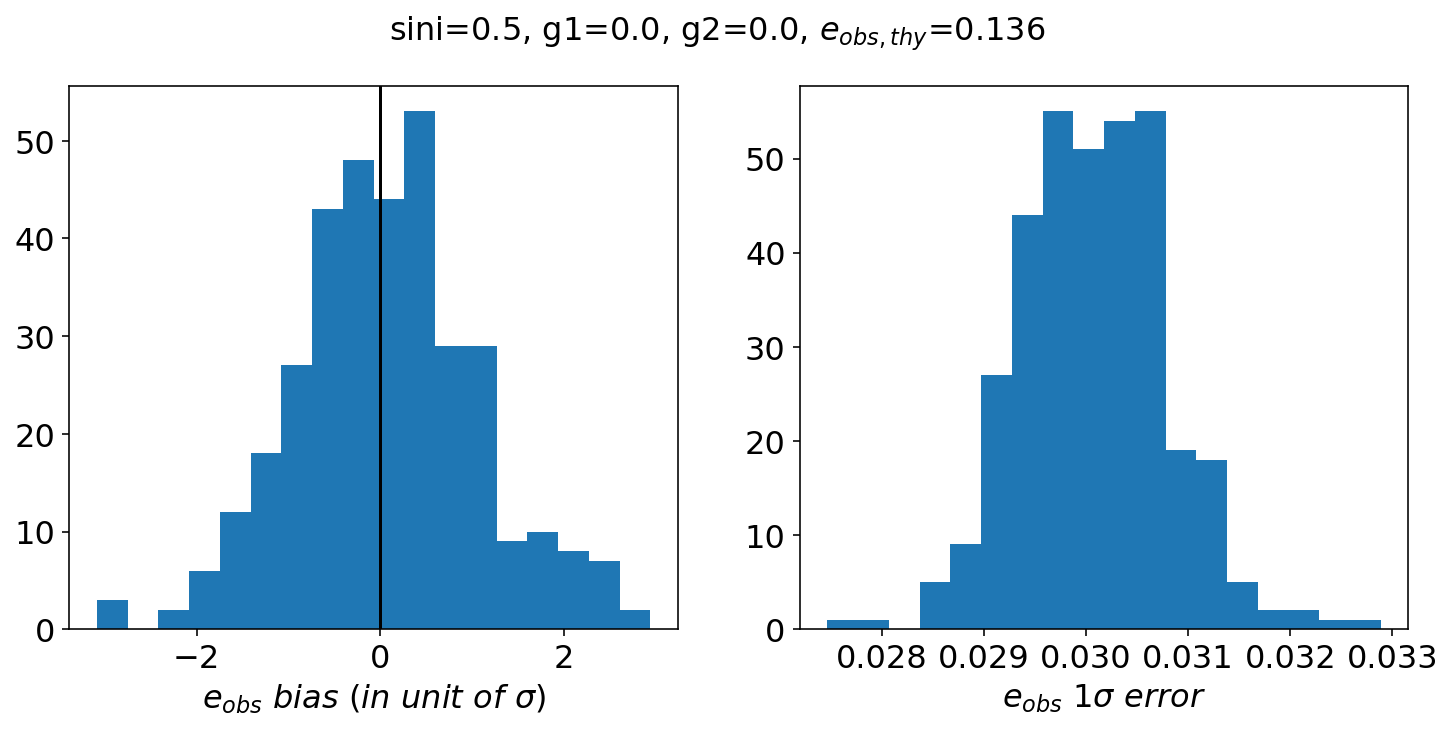

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plt.rc('font',size=16)


N1, bin1, _ = ax[0].hist(stat_info['e_obs_bias_sigma'], bins=18)
N2, bin2, _ = ax[1].hist(stat_info['e_obs_err']       , bins=18)

ax[0].axvline(x=0, color='k')

fig.suptitle(f'sini={sini}, g1={g1}, g2={g2}, '+'$e_{obs, thy}$='+f'{eobs_thy:.3f}', fontsize=16)

ax[0].set_xlabel('$e_{obs}\ bias\ (in\ unit\ of\ \sigma)$', fontsize=16)
ax[1].set_xlabel('$e_{obs}\ 1\sigma\ error$', fontsize=16)

# === Past record ===

## g1=0.05, g2=0.05

In [32]:
e_obs_bias_sigma = list(np.array([ 1.12553186,  0.27727116, -2.28191464,  0.7787235 ,  0.84853303,
       -1.82542933, -1.45818537, -0.35525304, -0.4638627 ,  1.4674877 ,
        1.31824032, -0.8815605 ,  1.41228661,  0.32014609, -0.29045892,
        0.75812988,  0.35940089, -1.45098446,  0.00636476, -0.13112092,
        0.24499874, -1.42012782,  0.22539339, -2.21139298,  1.30445068,
       -0.13224568,  0.70964454, -0.28359429,  0.23239265,  0.91656672]))

In [34]:
e_obs_err=list(np.array([0.03015715, 0.02938704, 0.02957445, 0.02976847, 0.03044686,
       0.03072178, 0.02915471, 0.02917169, 0.03164596, 0.03149022,
       0.0297907 , 0.03079895, 0.02967233, 0.03106162, 0.02993919,
       0.02975519, 0.0303027 , 0.03018077, 0.03080472, 0.02985553,
       0.03032409, 0.03033063, 0.03041959, 0.03023466, 0.02998868,
       0.03094069, 0.02986662, 0.03071534, 0.03104558, 0.03039364]))

Text(0.5, 0, '$e_{obs}\\ 1\\sigma\\ error$')

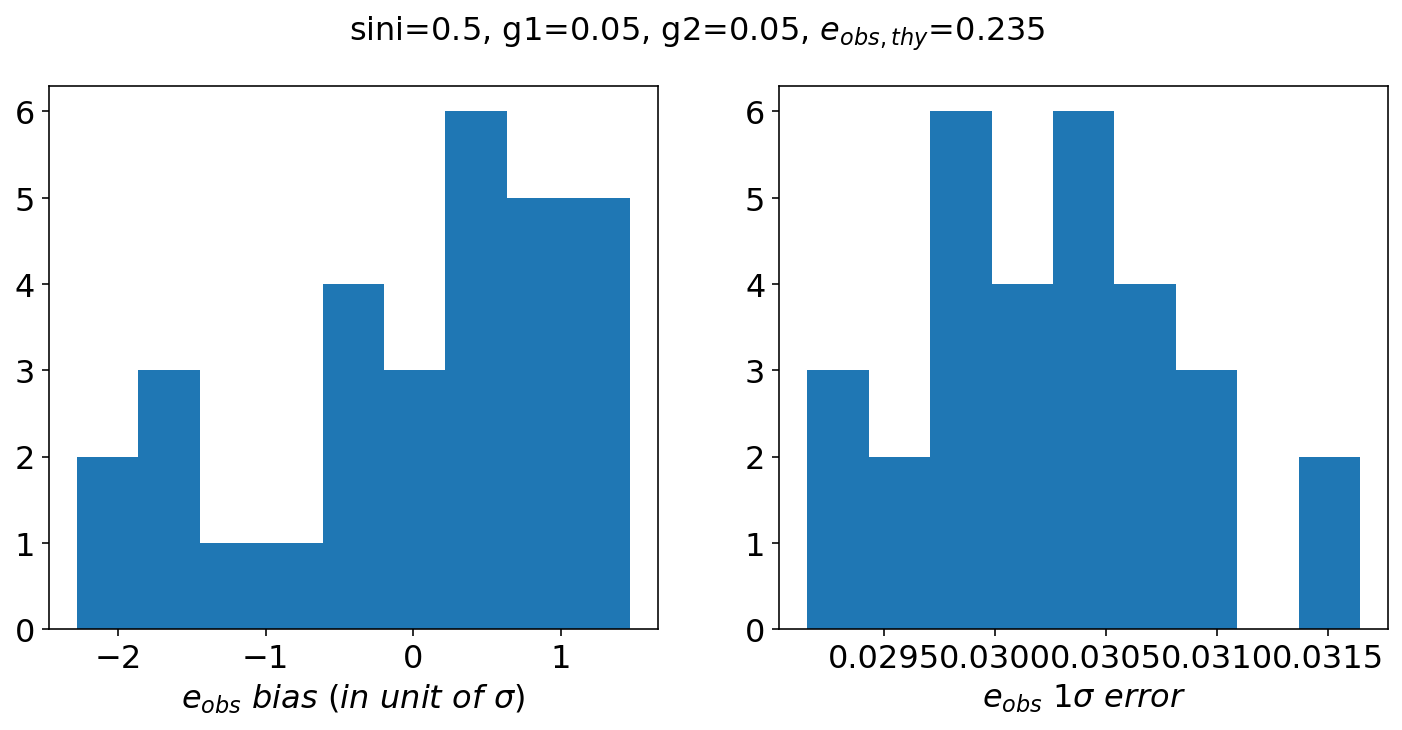

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plt.rc('font',size=16)


N1, bin1, _ = ax[0].hist(e_obs_bias_sigma, bins=9)
N2, bin2, _ = ax[1].hist(list_e_obs_err, bins=9)


fig.suptitle(f'sini={sini}, g1={g1}, g2={g2}, '+'$e_{obs, thy}$='+f'{eobs_thy:.3f}', fontsize=16)

ax[0].set_xlabel('$e_{obs}\ bias\ (in\ unit\ of\ \sigma)$', fontsize=16)
ax[1].set_xlabel('$e_{obs}\ 1\sigma\ error$', fontsize=16)

## g2=0.05

In [39]:
e_obs_bias_sigma = list(np.array([ 2.71980051, -0.1777376 , -0.14259864,  0.09876826, -0.72310509,
        0.74570723, -1.93155716, -0.52673853,  1.4419161 , -0.06178189,
        1.19899798,  0.28811279, -0.69276285, -1.11216263,  1.96424662,
        0.95804948,  0.07825196,  1.22610294,  0.16012668, -0.59497338,
       -0.5425963 ,  0.60230743,  0.41852405,  0.3543053 , -0.69765072,
       -0.26477076,  0.04763824, -0.39423799, -0.68230401,  1.5476703 ]))

In [40]:
e_obs_err = list(np.array([0.0312613 , 0.03168819, 0.03042078, 0.03122622, 0.03087097,
       0.03040244, 0.03017666, 0.03003125, 0.03057317, 0.03021217,
       0.03101893, 0.03080259, 0.03099477, 0.02975695, 0.03024801,
       0.0301357 , 0.03176475, 0.03033399, 0.03053027, 0.03098629,
       0.02979077, 0.03016124, 0.03117183, 0.0302662 , 0.02913844,
       0.03068681, 0.03079671, 0.03045253, 0.0299735 , 0.03061799]))

In [41]:
stat_info={}
stat_info['e_obs_bias_sigma'] = e_obs_bias_sigma
stat_info['e_obs_err'] = e_obs_err
save_pickle("e_obs_g1_0.00_g2_0.05.pkl", stat_info)

Text(0.5, 0, '$e_{obs}\\ 1\\sigma\\ error$')

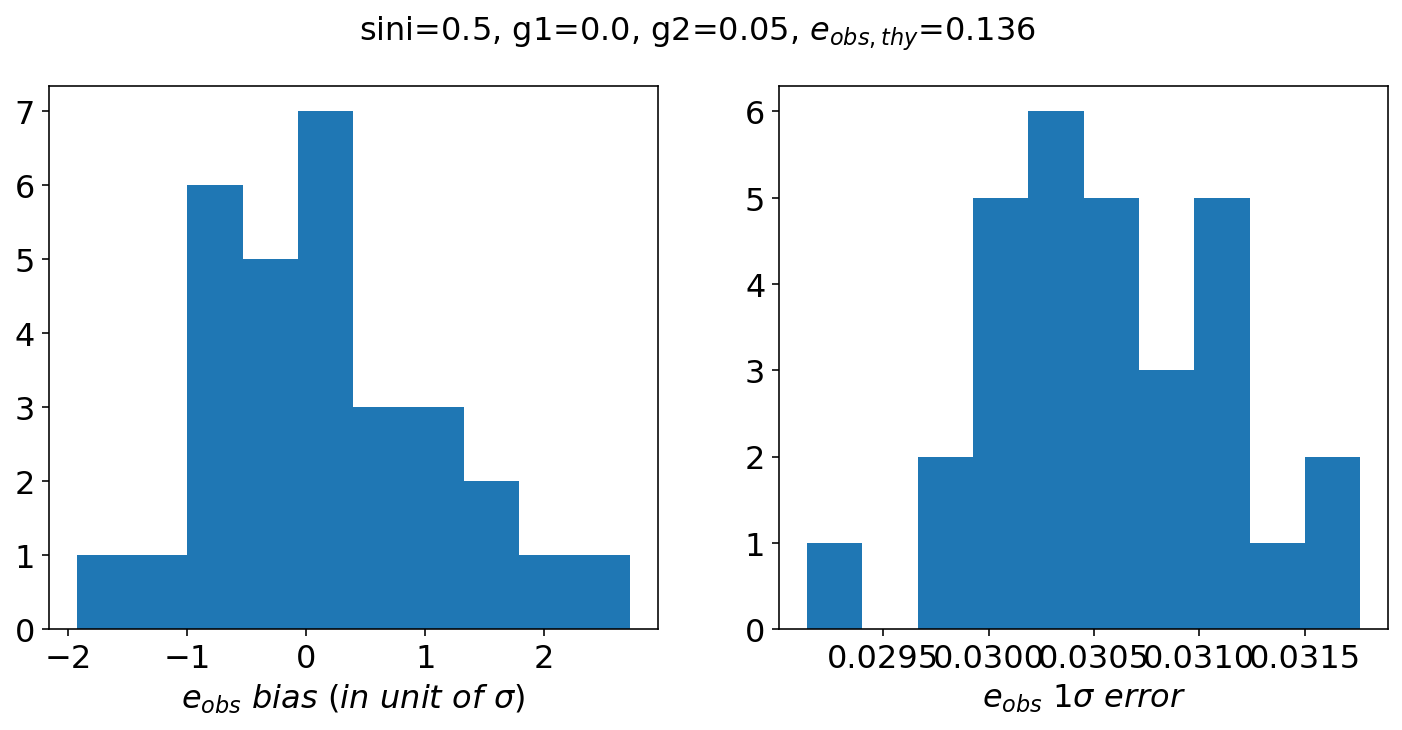

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plt.rc('font',size=16)


N1, bin1, _ = ax[0].hist(e_obs_bias_sigma, bins=10)
N2, bin2, _ = ax[1].hist(list_e_obs_err, bins=10)


fig.suptitle(f'sini={sini}, g1={g1}, g2={g2}, '+'$e_{obs, thy}$='+f'{eobs_thy:.3f}', fontsize=16)

ax[0].set_xlabel('$e_{obs}\ bias\ (in\ unit\ of\ \sigma)$', fontsize=16)
ax[1].set_xlabel('$e_{obs}\ 1\sigma\ error$', fontsize=16)

## g1=0.0, g2=0.0

In [45]:
e_obs_bias_sigma = list(np.array([ 0.03691551,  1.48116244, -0.35247505,  0.8628927 , -0.48546616,
       -1.63284493,  2.24816164, -0.30194216, -0.8813615 , -0.70573018,
       -0.63604288,  0.53998361, -1.33362996,  0.16940828,  2.63602456,
        0.16276981, -0.46789633,  2.21015592,  0.5010352 ,  1.15421176,
        1.19522846, -0.43488474, -0.65922723,  0.78086878,  0.07762173,
        0.19833113, -0.1236604 , -0.78189195, -0.26171655,  1.34103114]))


e_obs_err=list(np.array([0.03136669, 0.02874884, 0.03041984, 0.02970299, 0.03032297,
       0.02999427, 0.03013054, 0.03070758, 0.03108642, 0.03113482,
       0.02997666, 0.03163305, 0.02930114, 0.02998303, 0.02984065,
       0.03072571, 0.02973582, 0.03026143, 0.02976374, 0.03102432,
       0.02967741, 0.02930295, 0.02980852, 0.03066868, 0.03081245,
       0.03055537, 0.02995686, 0.02964227, 0.02963216, 0.02986836]))

In [46]:
stat_info={}
stat_info['e_obs_bias_sigma'] = e_obs_bias_sigma
stat_info['e_obs_err'] = e_obs_err
save_pickle("e_obs_g1_0.00_g2_0.00.pkl", stat_info)

Text(0.5, 0, '$e_{obs}\\ 1\\sigma\\ error$')

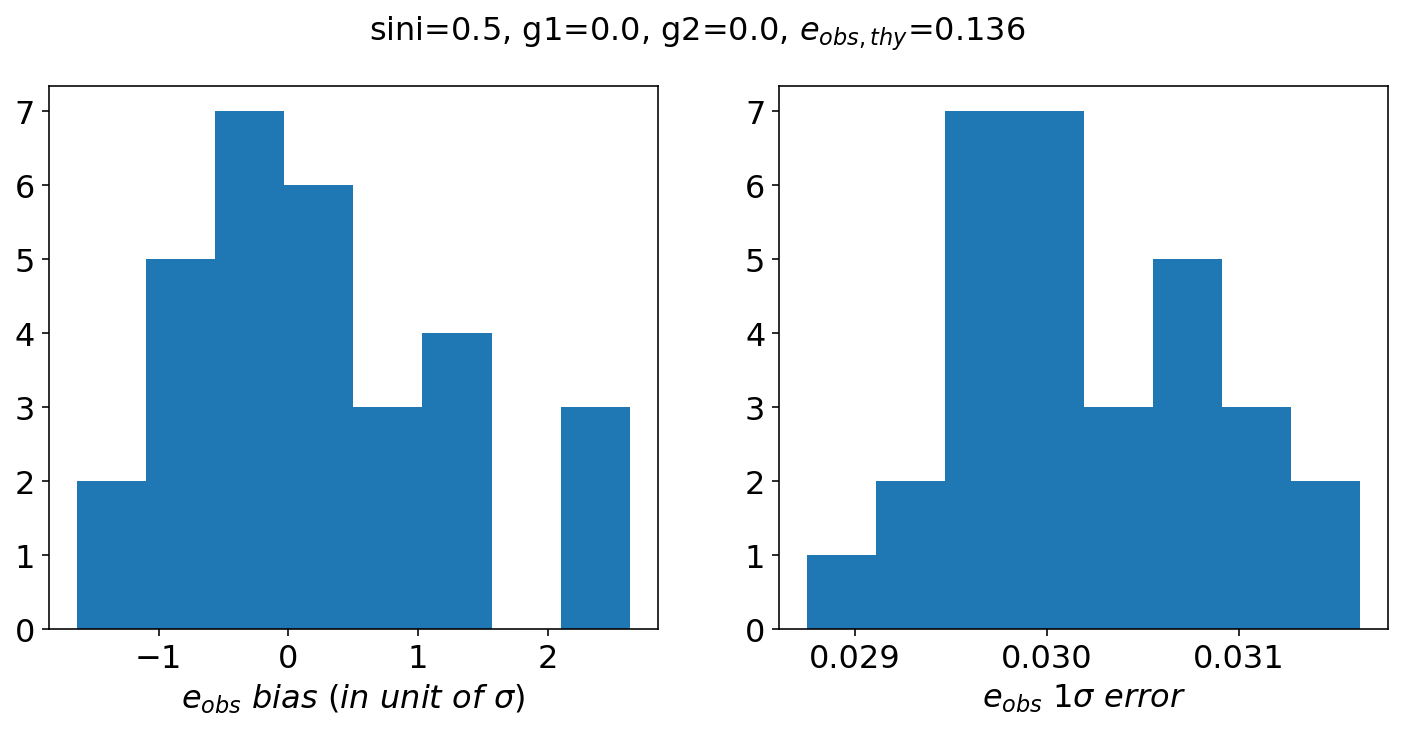

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plt.rc('font',size=16)


N1, bin1, _ = ax[0].hist(e_obs_bias_sigma, bins=8)
N2, bin2, _ = ax[1].hist(list_e_obs_err, bins=8)


fig.suptitle(f'sini={sini}, g1={g1}, g2={g2}, '+'$e_{obs, thy}$='+f'{eobs_thy:.3f}', fontsize=16)

ax[0].set_xlabel('$e_{obs}\ bias\ (in\ unit\ of\ \sigma)$', fontsize=16)
ax[1].set_xlabel('$e_{obs}\ 1\sigma\ error$', fontsize=16)